### Dans ce notebook nous analyserons en détail l'architecture d'AESTRA afin de mieux la comprendre.

# Imports

In [ ]:
import pickle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset
import time
import pandas as pd
from util import SpectrumDataset

## Voici l'architecture complète du réseau :

![image](full_architecture.png)


Le réseau est constitué de deux parties principales :
- **L'auto-encodeur** (SPENDER)
- Le **RV Estimator**

### Comment comprendre chaque partie ?

- Le but de l'auto-encodeur est d'apprendre à **reconstruire** le signal **issu uniquement de l'activité**. En apprenant à reconstruire **issu uniquement de l'activité**, il apprend aussi à **caractériser l'activité stellaire** des spectres qu'on lui donne.

- Le but du **RV Estimator** est d'apprendre les **shifts doppler pur**, son but est de calculer la vitesse radiale d'un spectres dû à un mouvement radial de l'étoile et non à l'activité (d'où le terme shift *pur*).

- Le but du réseau **entier** lors de l'entraînement est de **reconstruire** le spectre d'origine $\mathbf{y_{obs}}$ à partir du spectre d'activité $\mathbf{y_{act}}$ issu du l'auto-encodeur et de la vitesse radiale $v_{encode}$. On s'attend grâce au losses imposées que le réseau apprennent d'un côté à séparer le signal d'activité et de l'autre le signal "radial". 

### Comment ça marche ?

Dans les grandes lignes, pour comprendre comment tout cela peut marcher, il faut regarder ce qui est **imposé** au réseau.

Mais comment l'auto-encodeur apprend à reconstruire le signal contenant uniquement l'activité $\mathbf{y_{act}}$ ? 

Il apprend à reconstruire le signal car on le lui **impose**. En effet on impose à l'auto-encodeur la loss suivante : 
$$L_{\text{fid}} = \frac{1}{NL} \sum_{i=1}^{N} \left\| \mathbf{w}_i \odot \left( \mathbf{y}_{i,\text{obs}} - \mathbf{y}'_{i,\text{obs}} \right) \right\|^2$$

Au fur et à mesure des epochs (cycles d'entraînement), cette loss diminue et donc impose que $\mathbf{y_{obs}'}$ soit le plus proche de $\mathbf{y_{obs}}$ le signal d'origine.

Cependant, le fait d'imposer la loss ne suffit pas à ce que n'importe quel réseau réussisse n'importe quelle tâche. Il faut construire une architecture cohérente qui lui permettent d'apprendre lors de l'entraînement.

C'est ce que nous allons découvrir tout au long de ce notebook, comment l'auto-encodeur arrive à caractériser l'activité stellaire d'un spectre ? Comment le RV-Estimator arrive à prédire les vitesses radiales à partir d'un spectre seul sans masque ? etc. 


# I . Les blocs de convolutions

Quand on jette un coup d'oeil à l'architecture de réseau, on voit le terme `convblock` revenir, ces blocs de convolution se trouvent dans le RV-Estimator et dans l'auto-encodeur, à quoi servent-ils et pourquoi ils marchent si bien dans le cadre de notre problème

## I.a) Qu'est ce qu'une convolution en 1D sur notre spectre ?

![convolution_1d](conv1d.gif)


Chaque bloc de convolution commence par une `couche de convolution`. 

La première couche de convolution du réseau prend le spectre $\mathbf{y_{obs}}$ en entrée, et le parcourt à l'aide de noyaux (kernel) qui vont convoluer le spectre avec leur paramètres. 

Les coefficients du noyeau sont apprenables par le réseau et vont donc s'ajuster en fonction de la loss pour répondre à la problématique posée.

Il faut comprendre cette convolution comme une **extraction de caractéristiques**. 

Dans notre cas, les couches successives de convolution au sein de l'auto-encodeur **extraient les caractéristique liés à l'activité stellaire au sein du spectre**.

## I.b) De quoi est composé notre bloc de convolution ?

Les couches de convolutions seules ne permettent pas d'extraire les caractéristiques, il nous faut d'autres couches pour les aider. Généralement, un bloc de convolution contient deux autres éléments essentiels : 

- Une fonction d'activation
- Une couche de MaxPooling



### La fonction d'activation

La fonction d'activation rajoute de la **non-linéarité** à notre modèle. Jusqu'à présent on ne faisait que des combinaisons linéaires, mais ce qui décuple la puissance du réseau et sa faculté à extraire les caractéristique, c'est de rajouter en plus cette fonction d'activation non-linéaire qui sert à **complexifier** le réseau et le rendre performant sur des problèmes **complexes**.

In [81]:
x1prime + x2

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7]

In [84]:
x1prime + x2

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7]

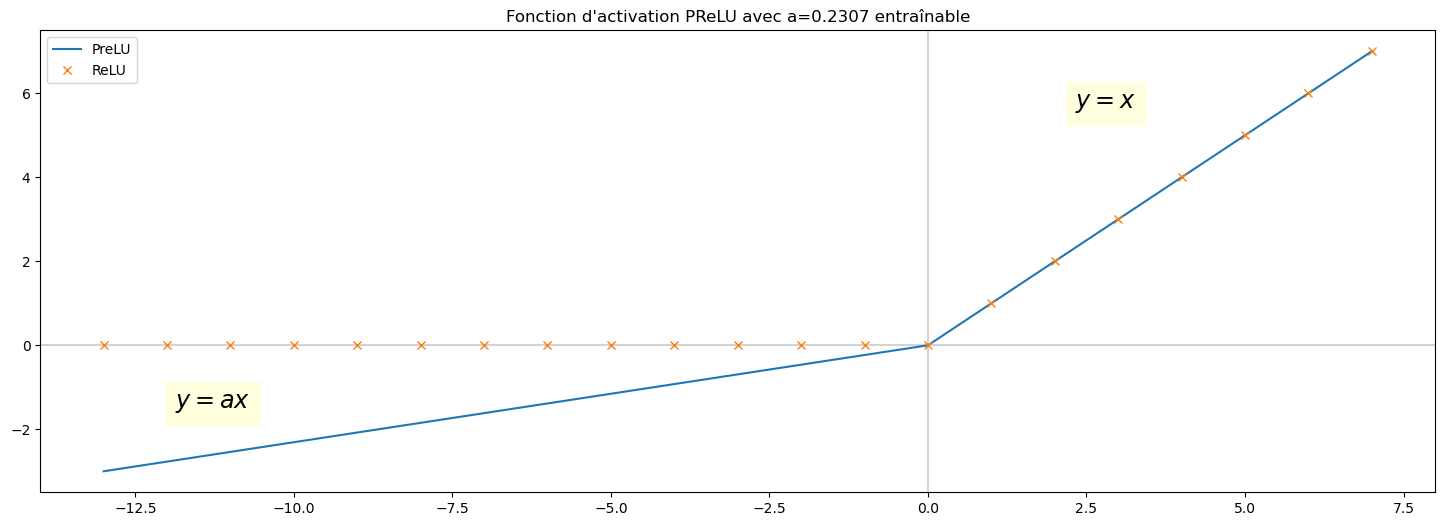

In [85]:
state_dict = torch.load('RV_Estimator.pth')

a = state_dict['conv1.2.weight'][0].item()

x1 = [k for k in range(-13, 0)]
y1prime = [0 for k in range(-13, 0)]
x2 = [k for k in range(0, 8)]

y1 = [a * k for k in range(-13, 0)]
y2 = [k for k in range(0, 8)]

plt.figure(figsize=(18, 6))
plt.title(f"Fonction d'activation PReLU avec a={a:.4f} entraînable")
plt.axhline(y=0, color='lightgrey')
plt.axvline(x=0, color='lightgrey')
plt.plot(x1 + x2, y1 + y2, label='PreLU')  
plt.plot(x1 + x2, y1prime + x2, label='ReLU', linestyle='None', marker='x')
plt.figtext(x=0.2, y=0.25, s=r"$y = ax$", backgroundcolor='lightyellow', fontsize='xx-large')
plt.figtext(x=0.7, y=0.75, s=r"$y = x$", backgroundcolor='lightyellow', fontsize='xx-large')
plt.legend()  
plt.show()

On applique cette la fonction $\text{PreLU}$ qui à l'inverse de ReLU (fonction classique), permet de conserver les valeurs négatives